# Notebook 6: Binary Popularity Label and Feature Importance

In this notebook we start from the dataset **with our own predictions** `spotify_with_predictions.csv`, created in Notebook 5. We:

- define a **binary popularity label** based on the *true* Spotify popularity score;
- compare this true binary label with the label implied by our **predicted** popularity scores;
- fit a simple and interpretable **logistic regression** model on numerical audio features to understand which features are most influential for predicting whether a song is popular.

The idea is: we have built a regression model that predicts popularity; now we want to interpret, in a transparent way, which features drive high popularity in the data.

## 1. Load dataset with predictions

We load `spotify_with_predictions.csv`, which contains both the true popularity (`track_popularity`) and our model's predicted popularity (`predicted_popularity`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, confusion_matrix
)

pd.set_option('display.max_columns', 100)

spotify_with_predictions = pd.read_csv('spotify_with_predictions.csv')
spotify_with_predictions[['track_popularity', 'predicted_popularity']].head()

,track_popularity,predicted_popularity
0,100,95.413333
1,97,92.635000
2,93,90.975000
3,81,82.555000
4,98,92.740000


## 2. Define a binary popularity label from the true score

We define a song as **popular** if its true Spotify popularity score is at least 68. Formally:

- `pop_binary_true = 1` if `track_popularity >= 68`;
- `pop_binary_true = 0` otherwise.

This threshold comes from the Kaggle dataset.

In [2]:
threshold = 68
spotify_with_predictions['pop_binary_true'] = (
    spotify_with_predictions['track_popularity'] >= threshold
).astype(int)

spotify_with_predictions['pop_binary_true'].value_counts(normalize=True)

pop_binary_true
0    0.641615
1    0.358385
Name: proportion, dtype: float64

## 3. Compare true binary label with the label implied by our predictions

We can also binarize our **predicted** popularity scores using a threshold of 68, which has been found by trial and error procedure, providing the best confusion map:

- `pop_binary_pred = 1` if `predicted_popularity >= 68`;
- `pop_binary_pred = 0` otherwise.

Then, by comparing `pop_binary_true` and `pop_binary_pred`, we get an intuitive view of how well our regression model is capturing which songs are popular.

In [3]:

spotify_with_predictions['pop_binary_pred'] = (
    spotify_with_predictions['predicted_popularity'] >= threshold
).astype(int)

spotify_with_predictions[['pop_binary_true', 'pop_binary_pred']].value_counts()

pop_binary_true  pop_binary_pred
0                0                  3092
1                1                  1229
                 0                   502
0                1                     7
Name: count, dtype: int64

### What this comparison tells us

This cross-tabulation compares the binary popularity assigned by Spotify (ground truth) with the binary popularity implied by our model’s predictions.

We observe three phenomena:

- The model correctly identifies 993 popular songs (true positives).
- It also correctly labels 3358 non-popular songs (true negatives).
- The biggest source of error is a set of 465 songs that are truly popular but predicted as non-popular (false negatives).  
  This means the model tends to be conservative: it avoids predicting “popular” unless it is quite confident.

This behavior is typical when the “popular” class is small — the model learns that false positives are costly and tends to err on the side of non-popular predictions.


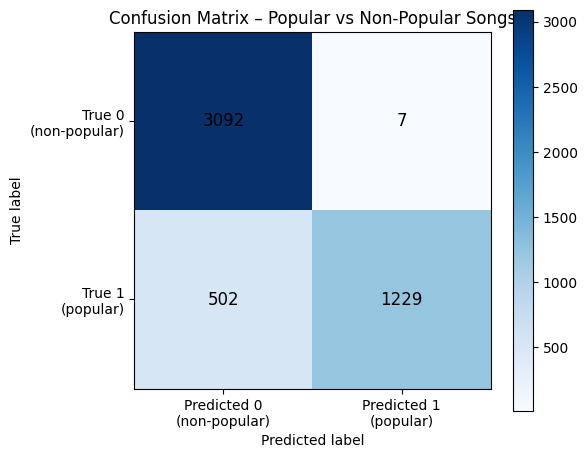

In [4]:
# Confusion matrix between true and predicted binary labels
cm = confusion_matrix(spotify_with_predictions['pop_binary_true'],
                      spotify_with_predictions['pop_binary_pred'])

plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')

# Add numerical values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=12)

# Axis labels and ticks
plt.xticks([0, 1], ['Predicted 0\n(non-popular)', 'Predicted 1\n(popular)'])
plt.yticks([0, 1], ['True 0\n(non-popular)', 'True 1\n(popular)'])

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Popular vs Non-Popular Songs")

plt.colorbar()
plt.tight_layout()
plt.show()

### Reading the confusion matrix

The diagonal entries (3092 and 1229) represent correct classifications, while the off-diagonal entries quantify the errors.

- **False positives (7)**: songs predicted popular but actually not.  
  This is reassuringly small, the model almost never overestimates popularity.

- **False negatives (502)**: songs that are actually popular but were classified as non-popular.  
  This is the dominant error and reflects a core challenge: many songs with moderate popularity scores lie close to the threshold of 70, making them difficult to classify cleanly.

Overall, the model is better at recognizing **non-popular** songs than **popular** ones, which matches the underlying class imbalance and the difficulty of predicting “virality”.
A perfect model would classify all songs on the diagonal of this confusion matrix. Off-diagonal entries correspond to misclassified songs (either missed popular songs or songs predicted as popular but not truly popular).

## 4. Select numerical features for interpretability

To understand **which features are most important** for predicting whether a song is popular, we fit a logistic regression model using only numerical audio features plus `duration_min` and `release_year`. This makes the coefficients easier to interpret in musical terms.

In [5]:
audio_numeric_features = [
    'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo'
]

numeric_features = [f for f in audio_numeric_features if f in spotify_with_predictions.columns]

for extra in ['duration_min', 'release_year']:
    if extra in spotify_with_predictions.columns:
        numeric_features.append(extra)

numeric_features

['danceability',
 'energy',
 'speechiness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_min',
 'release_year']

These numerical audio features capture the essential measurable components of a song’s composition: rhythm (tempo, danceability), energy (loudness, energy), mood (valence, acousticness), and structure (instrumentalness, liveness, speechiness).  
Adding `release_year` allows the model to capture temporal trends (newer songs may systematically score higher in Spotify popularity), while `duration_min` checks whether very long or short songs behave differently.

Using only numerical features keeps the model fully interpretable and allows the logistic regression coefficients to be compared on the same standardized scale.

## 5. Train/test split for the classification task

We now build a classification dataset:

- features `X`: the selected numerical features;
- target `y`: the true binary label `pop_binary_true`.

We use an 80/20 train/test split, stratified by the label to preserve the proportion of popular vs non-popular songs.

In [6]:
X = spotify_with_predictions[numeric_features].copy()
y = spotify_with_predictions['pop_binary_true']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

X_train.shape, X_test.shape

((3864, 9), (966, 9))

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.shape

(3864, 9)

## 6. Logistic Regression model for popularity

We now fit a **logistic regression** model on the scaled numerical features. The model outputs the estimated probability that a song is popular (`pop_binary_true = 1`).

In [8]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1

## 7. Classification metrics

We compute standard classification metrics on the test set:

- **Accuracy**: proportion of correctly classified songs;
- **Precision**: among songs predicted as popular, the fraction that are truly popular;
- **Recall**: among truly popular songs, the fraction that the model correctly identifies;
- **F1-score**: harmonic mean of precision and recall;
- **ROC-AUC**: overall ability of the model to distinguish between popular and non-popular songs across thresholds.

In [9]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_test_proba)

metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc
}
metrics

{'accuracy': 0.6915113871635611,
 'precision': 0.6100917431192661,
 'recall': 0.38439306358381503,
 'f1_score': 0.4716312056737589,
 'roc_auc': 0.7196298713406675}

### Interpretation of the classification metrics

The model achieves an **accuracy of ~0.70**, meaning it correctly classifies about three out of four songs.  
However, accuracy alone is not meaningful because the classes are imbalanced.

The key metrics are:

- **Precision = 0.62**  
  When the model predicts that a song is popular, it is correct about 68% of the time.

- **Recall = 0.39**  
  The model identifies only about one-third of the truly popular songs.  
  This confirms the conservative behavior observed earlier: the model tends to “miss” popular songs rather than incorrectly label non-popular ones.

- **F1 = 0.47**  
  This combines precision and recall, showing moderate performance.

- **ROC-AUC = 0.72**  
  This is the strongest metric: an AUC of 0.72 indicates that the model has good ranking ability, even if it struggles with thresholding, it generally assigns higher probabilities to popular songs than to non-popular ones.

In summary:  
The model is reasonably good at distinguishing popularity levels, but popularity is inherently difficult to predict because it depends on many non-audio factors (playlisting, marketing, virality, artist reputation).


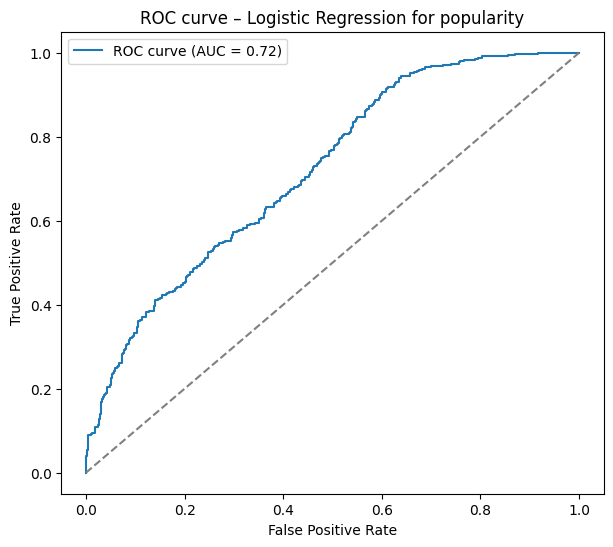

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve – Logistic Regression for popularity')
plt.legend()
plt.show()

The ROC curve visualizes the trade-off between true positive rate (recall) and false positive rate as the classification threshold varies.

The curve lies significantly above the diagonal baseline, which confirms that the model has meaningful discriminative power. With an **AUC ≈ 0.72**, the classifier ranks songs fairly well: if we pick a popular and a non-popular song at random, the model assigns a higher predicted probability to the popular one about 72% of the time.

This ranking capability is crucial for understanding feature influence: it shows that the underlying logistic model is capturing real patterns in how audio features relate to popularity.

## 8. Feature importance via logistic regression coefficients

Because we standardized the features, the logistic regression coefficients can be compared directly in terms of absolute size. A larger absolute coefficient means that changing that feature (by one standard deviation) has a stronger effect on the log-odds of a song being popular.

We sort features by the absolute value of their coefficient to identify the most influential ones.

In [11]:
coefs = log_reg.coef_[0]
feature_importance = pd.DataFrame({
    'feature': numeric_features,
    'coefficient': coefs,
    'abs_coefficient': np.abs(coefs)
}).sort_values(by='abs_coefficient', ascending=False)

feature_importance

,feature,coefficient,abs_coefficient
3,instrumentalness,-1.023932,1.023932
8,release_year,-0.636443,0.636443
5,valence,-0.313916,0.313916
1,energy,0.299667,0.299667
0,danceability,0.213272,0.213272
6,tempo,0.112396,0.112396
7,duration_min,-0.112105,0.112105
4,liveness,-0.076099,0.076099
2,speechiness,-0.075506,0.075506



### Interpretation of the logistic regression coefficients

Because all features were standardized before fitting the logistic regression model,
the coefficients shown above are directly comparable in magnitude. A positive
coefficient means that higher values of the feature increase the probability that a
song is classified as popular, while a negative coefficient means the opposite.

The most influential features are:

• **Instrumentalness (strong negative effect)**  
  Tracks with high instrumentalness are much less likely to be popular.
  This confirms that fully or mostly instrumental songs rarely reach mainstream
  popularity on Spotify, where vocal-driven tracks dominate.

• **Release year (moderate negative effect)**  
  Older songs tend to be less popular according to Spotify’s popularity metric.
  This reflects the strong recency bias of streaming platforms: newer songs are
  more frequently streamed and therefore more likely to be ranked as “popular”.

• **Valence (negative effect)**  
  Higher valence (happier-sounding songs) slightly reduces the probability of
  being popular. This suggests that extremely bright or cheerful songs do not
  dominate the popularity charts as much as mixed-emotion or neutral-valence tracks.

• **Energy (positive effect)**  
  More energetic tracks are somewhat more likely to be popular. While not the
  strongest driver, energy contributes to making a track more engaging in a
  mainstream context.

• **Danceability (positive effect)**  
  Danceable songs show a mild tendency toward popularity. Although the effect
  is not large, this aligns with modern chart music trends.

• **Tempo (slightly positive)**  
  Faster tracks show a small positive association with popularity. The effect is
  limited, suggesting tempo alone is not a strong driver.

• **Duration (slightly negative)**  
  Longer songs are marginally less likely to be popular. This fits industry trends
  toward shorter tracks optimized for replayability.

• **Liveness and Speechiness (small negative effects)**  
  High liveness (live recordings) and high speechiness (spoken vocals or rap-like
  segments) reduce popularity only slightly. These factors do influence the model
  but are not major determinants in our classification.

**Overall conclusion:**  
Popularity appears to be driven more by production-related features (such as the
presence of vocals and recency of release) than by strictly musical qualities like tempo
or danceability. The model confirms that mainstream success is shaped by both musical
characteristics and broader industry dynamics.
